## Welcome

This is material for the **Matching and Subclassification** chapter in Scott Cunningham's book, [Causal Inference: The Mixtape.](https://mixtape.scunning.com/)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from itertools import combinations

In [5]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

def read_data(file):
    full_path = "https://raw.github.com/scunning1975/mixtape/master/" + file
    
    return pd.read_stata(full_path)
    

In [6]:
# Subclassification
##Read data
titanic = read_data("titanic.dta")

In [7]:
titanic['d'] = 0
titanic.loc[titanic['class']=='1st class', 'd'] = 1

titanic['sex_d'] = 0
titanic.loc[titanic['sex']=='man', 'sex_d'] = 1

titanic['age_d'] = 0
titanic.loc[titanic['age']=='adults', 'age_d'] = 1

titanic['survived_d'] = 0
titanic.loc[titanic['survived']=='yes', 'survived_d'] = 1


In [8]:
## Simple Difference in Outcomes
ey0 = titanic.loc[titanic['d']==0, 'survived_d'].mean()
ey1 = titanic.loc[titanic['d']==1, 'survived_d'].mean()

sdo = ey1 - ey0
print("The simple difference in outcomes is {:.2%}".format(sdo))

The simple difference in outcomes is 35.38%


In [9]:
## Weighted Average Treatment Effect 
titanic['s'] = 0 
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==1), 's'] = 1
titanic.loc[(titanic.sex_d == 0) & (titanic.age_d==0), 's'] = 2
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==1), 's'] = 3
titanic.loc[(titanic.sex_d == 1) & (titanic.age_d==0), 's'] = 4

obs = titanic.loc[titanic.d == 0].shape[0]

def weighted_avg_effect(df):
    diff = df[df.d==1].survived_d.mean() - df[df.d==0].survived_d.mean()
    weight = df[df.d==0].shape[0]/obs
    return diff*weight

wate = titanic.groupby('s').apply(weighted_avg_effect).sum()

print("The weighted average treatment effect estimate is {:.4%}".format(wate))  

The weighted average treatment effect estimate is 18.8785%


# Questions
- Using the simple difference in outcomes, how much does the probability of survival increase for first-class passengers relative to some control group?
- Explain in your own words what stratifying on gender and age did for this difference in outcomes between treatment and control?
- After stratifying on gender and age, what happens to the difference in probability of survival between first-class and non-first-class passengers?



## Training Example

First, we will look at the distribution of age between the treated and non-treated groups

In [ ]:
training_example = read_data("training_example.dta")

,unit_treat,age_treat,earnings_treat,unit_control,age_control,earnings_control,unit_matched,age_matched,earnings_matched
20,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
21,NaN,24.3,11075,NaN,31.95,11101.25,NaN,NaN,9380.0
22,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,SDO,-26.25,NaN,NaN,NaN,NaN,NaN
24,NaN,NaN,ATE,1695.00,NaN,NaN,NaN,NaN,NaN


(array([2., 1., 2., 0., 1., 0., 1., 1., 1., 1.]),
 array([18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. ]),
 <a list of 10 Patch objects>)

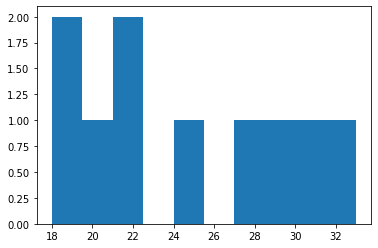

In [ ]:
plt.hist(training_example.age_treat, bins = 10) 

(array([4., 2., 1., 3., 2., 1., 4., 1., 0., 2.]),
 array([18. , 21.3, 24.6, 27.9, 31.2, 34.5, 37.8, 41.1, 44.4, 47.7, 51. ]),
 <a list of 10 Patch objects>)

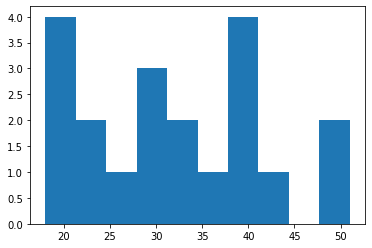

In [ ]:
plt.hist(training_example.age_control, bins = 10)

(array([2., 1., 2., 0., 1., 0., 1., 1., 1., 1.]),
 array([18. , 19.5, 21. , 22.5, 24. , 25.5, 27. , 28.5, 30. , 31.5, 33. ]),
 <a list of 10 Patch objects>)

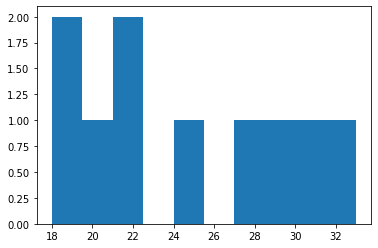

In [ ]:
plt.hist(training_example.age_matched, bins = 10)

#### Questions

- Compare the distribution of ages between the treated and the control groups. How do they differ, if at all?


In [10]:
# Approximate Matching
## Bias Correction
training_bias_reduction = read_data("training_bias_reduction.dta") 

In [11]:
training_bias_reduction['Y1'] = 0
training_bias_reduction.loc[training_bias_reduction['Unit'].isin(range(1,5)), 'Y1'] = 1
training_bias_reduction['Y0'] = (4,0,5,1,4,0,5,1)

In [12]:
train_reg = sm.OLS.from_formula('Y ~ X', training_bias_reduction).fit()
training_bias_reduction['u_hat0'] = train_reg.predict(training_bias_reduction)
training_bias_reduction = training_bias_reduction[['Unit', 'Y1', 'Y0', 'Y', 'D', 'X', 'u_hat0']]

training_bias_reduction



,Unit,Y1,Y0,Y,D,X,u_hat0
0,1,1,4,5,1,11,3.888071
1,2,1,0,2,1,7,4.082474
2,3,1,5,10,1,5,4.179676
3,4,1,1,6,1,3,4.276878
4,5,0,4,4,0,10,3.936672
5,6,0,0,0,0,8,4.033873
6,7,0,5,5,0,4,4.228277
7,8,0,1,1,0,1,4.374080


## National Supported Work Demonstration Experiment

To compare results, let's first look at the treatment effect identified by a true experiment.


In [13]:
nsw_dw = read_data('nsw_mixtape.dta')

mean1 = nsw_dw[nsw_dw.treat==1].re78.mean()
mean0 = nsw_dw[nsw_dw.treat==0].re78.mean()
ate = np.unique(mean1 - mean0)[0]
print("The experimental ATE estimate is {:.2f}".format(ate))

The experimental ATE estimate is 1794.35


#### Questions
- How do you interpret the above estimated ATE?
- Say you were interested in the ATT.  Can you report the ATT from a randomized experiment?  If so, what is it? If not, why not?



Now, lets turn to a non-experimental control group. We first have to load the data from the CPS. and estimate the propensity score


In [14]:
# Prepare data for logit 
nsw_dw_cpscontrol = read_data('cps_mixtape.dta')

In [15]:
nsw_dw_treated = nsw_dw[nsw_dw['treat']==1] 

In [16]:
nsw_dw_cpscontrol = pd.concat((nsw_dw_cpscontrol, nsw_dw_treated))
nsw_dw_cpscontrol[['u74', 'u75']] = 0
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re74==0, 'u74'] = 1
nsw_dw_cpscontrol.loc[nsw_dw_cpscontrol.re75==0, 'u75'] = 1
# estimating propensity score
logit_nsw = smf.glm(formula="""treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + I(educ*re74)""", 
                    family=sm.families.Binomial(),
                   data=nsw_dw_cpscontrol).fit()
                  
nsw_dw_cpscontrol['pscore'] = logit_nsw.predict(nsw_dw_cpscontrol)

In [17]:
nsw_dw_cpscontrol.groupby('treat')['pscore'].mean()

treat
0.0    0.006648
1.0    0.425357
Name: pscore, dtype: float64

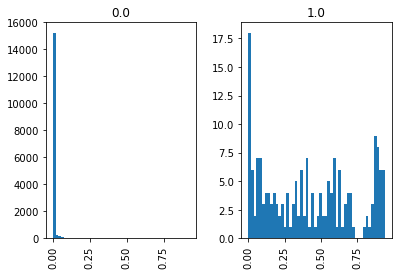

In [18]:
histpsc = nsw_dw_cpscontrol.hist(column = 'pscore', by = 'treat', bins = 50)

#### Questions
- Compare the mean propensity score between the treated and the control groups. What does this reveal about the two groups?
- Compare the distribution of propensity scores between the treated and the control groups. How do they differ, if at all?


In [19]:
# Continuation
N = nsw_dw_cpscontrol.shape[0]

# Manual with non-normalized weights using all data
nsw_dw_cpscontrol['d1'] = nsw_dw_cpscontrol.treat/nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['d0'] = (1-nsw_dw_cpscontrol.treat)/(1-nsw_dw_cpscontrol.pscore)


s1 = nsw_dw_cpscontrol.d1.sum()
s0 = nsw_dw_cpscontrol.d0.sum()

nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_1 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (non-normalized, all data): {:.2f}".format(te_1))
        


Treatment Effect (non-normalized, all data): -11876.79


In [20]:
nsw_dw_cpscontrol['y1'] = nsw_dw_cpscontrol.treat * nsw_dw_cpscontrol.re78 / nsw_dw_cpscontrol.pscore
nsw_dw_cpscontrol['y1'] /= s1/N
nsw_dw_cpscontrol['y0'] = (1 - nsw_dw_cpscontrol.treat) * nsw_dw_cpscontrol.re78 / (1 - nsw_dw_cpscontrol.pscore)
nsw_dw_cpscontrol['y0'] /= s0/N
nsw_dw_cpscontrol['ht'] = nsw_dw_cpscontrol['y1'] - nsw_dw_cpscontrol['y0']

te_2 = nsw_dw_cpscontrol.ht.mean()

print("Treatment Effect (normalized, all data): {:.2f}".format(te_2))
        

Treatment Effect (normalized, all data): -7238.14


In [21]:
nsw_dw_trimmed = nsw_dw_cpscontrol.drop(['d1', 'd0', 'y1', 'y0'], axis=1)
nsw_dw_trimmed = nsw_dw_trimmed[nsw_dw_trimmed.pscore.between(.1, .9)]
N = nsw_dw_trimmed.shape[0]

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_3 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (non-normalized, trimmed data): {:.2f}".format(te_3))

Treatment Effect (non-normalized, trimmed data): 2006.37


In [22]:
nsw_dw_trimmed['d1'] = nsw_dw_trimmed.treat/nsw_dw_trimmed.pscore
nsw_dw_trimmed['d0'] = (1-nsw_dw_trimmed.treat)/(1-nsw_dw_trimmed.pscore)

s1 = nsw_dw_trimmed.d1.sum()
s0 = nsw_dw_trimmed.d0.sum()

nsw_dw_trimmed['y1'] = nsw_dw_trimmed.treat * nsw_dw_trimmed.re78 / nsw_dw_trimmed.pscore
nsw_dw_trimmed['y1'] /= s1/N
nsw_dw_trimmed['y0'] = (1 - nsw_dw_trimmed.treat) * nsw_dw_trimmed.re78 / (1 - nsw_dw_trimmed.pscore)
nsw_dw_trimmed['y0'] /= s0/N
nsw_dw_trimmed['ht'] = nsw_dw_trimmed['y1'] - nsw_dw_trimmed['y0']

te_4 = nsw_dw_trimmed.ht.mean()

print("Treatment Effect (normalized, trimmed data): {:.2f}".format(te_4))

Treatment Effect (normalized, trimmed data): 1806.73


#### Questions

- Explain the overlap condition in the context of these data.  How did we ensure that overlap held in the data? 
- When we are using non-trimmed data, why is the treatment effect negative? (*hint:* it has to do with extreme probability scores)
- What does this imply about the challenges of using non-experimental data when estimating causal effects, and why is conditioning on a trimmed propensity score important?


## Nearest-Neighbor Matching


In [1]:
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import IntVector, Formula
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind = 1)

<rpy2.rinterface_lib.sexp.NULLType object at 0x000001EF48D9D740> [RTYPES.NILSXP]

In [2]:
%%capture

# Install and import R packages
# MatchIt
utils.install_packages("MatchIt")
MatchIt = rpackages.importr("MatchIt")

# cem
utils.install_packages("cem")
cem = rpackages.importr("cem")

In [46]:
# Get formula
fmla = Formula(
    """treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ:re74"""
              )

# Convert the pandas df to an R/rpy2 DataFrame for use with the R packages
with localconverter(ro.default_converter + pandas2ri.converter):
      nsw_dw_cpscontrol_r = ro.conversion.py2rpy(nsw_dw_cpscontrol)

# Use 
m_out = MatchIt.matchit(fmla, data = nsw_dw_cpscontrol_r,
                 method = "nearest",
                 min_controls = 5)

m_data_r = MatchIt.match_data(m_out)

# Convert table back to pandas
with localconverter(ro.default_converter + pandas2ri.converter):
      m_data = ro.conversion.rpy2py(m_data_r)

# Run regression
m_ate = sm.OLS.from_formula('re78 ~ treat', data = m_data, weights = m_data['weights']).fit(cov_type = "HC2")

# Print summary
print(m_ate.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.910
Date:                Wed, 09 Mar 2022   Prob (F-statistic):              0.168
Time:                        13:03:53   Log-Likelihood:                -3817.5
No. Observations:                 370   AIC:                             7639.
Df Residuals:                     368   BIC:                             7647.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5294.1032    498.211     10.626      0.0

In [48]:
# Get formula
fmla = Formula(
    """treat ~ age + I(age**2) + I(age**3) + educ + I(educ**2) + 
                    marr + nodegree + black + hisp + re74 + re75 + u74 + u75 + educ:re74"""
              )

# Convert the pandas df to an R/rpy2 DataFrame for use with the R packages
with localconverter(ro.default_converter + pandas2ri.converter):
      nsw_dw_cpscontrol_r = ro.conversion.py2rpy(nsw_dw_cpscontrol)

# Use matchit from MatchIt R Package

m_out = MatchIt.matchit(fmla, data = nsw_dw_cpscontrol_r,
                 method = "cem",
                 min_controls = 5)

m_data_r = MatchIt.match_data(m_out)

# Convert table back to pandas
with localconverter(ro.default_converter + pandas2ri.converter):
      m_data = ro.conversion.rpy2py(m_data_r)

m_ate = sm.OLS.from_formula('re78 ~ treat', data = m_data, weights = m_data['weights']).fit(cov_type = "HC2")

# Print summary
print(m_ate.summary())

                            OLS Regression Results                            
Dep. Variable:                   re78   R-squared:                      -0.007
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                     5.216
Date:                Wed, 09 Mar 2022   Prob (F-statistic):             0.0237
Time:                        13:04:25   Log-Likelihood:                -1580.6
No. Observations:                 156   AIC:                             3165.
Df Residuals:                     154   BIC:                             3171.
Df Model:                           1                                         
Covariance Type:                  HC2                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4328.2908    557.902      7.758      0.0

#### Questions
- Compare our results from nearest-neighbor matching to what we found using the experimental data, the simple difference in outcomes using non-experimental controls, and propensity score weighting using non-experimental controls.
- DIFFICULT: Write a program that performs bootstrapping to get an estimate of the variance of the estimator. (HINT: Write a loop)

